In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import pandas as pd
import seaborn as sns

dataset = (
    pd.read_csv(r'winemag-data-130k-v2.csv')
)
dataset.drop(columns=["Unnamed: 0"])
display(dataset)


FileNotFoundError: ignored

# data analysis step:
1. null value observation

In [ ]:
(
    dataset
    .isna()
    .sum()
    .divide(dataset.shape[0])
    .sort_values(ascending = False)
    .multiply(100)
    .rename("null value percentage")
)

region_2                 61.136715
designation              28.825661
taster_twitter_handle    24.015357
taster_name              20.192197
region_1                 16.347493
price                     6.921544
country                   0.048472
province                  0.048472
variety                   0.000769
Unnamed: 0                0.000000
description               0.000000
points                    0.000000
title                     0.000000
winery                    0.000000
Name: null value percentage, dtype: float64

## dataset missing value action
1. region_2 : leave blank (for specific country analysis)
1. designation : drop missing
1. taster_twitter_handle : transform to hv_twit column
1. taster_name : fill value "annoymous"
1. region_1 : leave blank (for specific country analysis)
1. country : drop missing
1. price : drop missing
1. province : drop missing
1. variety : drop missing

In [ ]:
df = (  # data cleaning
    dataset
    .assign(
        # fill missing value with 'annoymous'
        taster_name = lambda df_: df_.taster_name.fillna("annoymous"),
        # transform taster_twitter_handle to show the taster whether have twitter
        hv_twit = ~dataset.taster_twitter_handle.isna()
        )
    # drop the original column
    #.drop(columns = ['taster_twitter_handle'])
    # execute the rows dropping
    .dropna(
        subset = ['variety', 'province', 'price', 'country', 'designation'],
        how = 'any'
        )
    .reset_index(drop = True)
    # refine the data type for optimization
    .astype(
        {
            'points'  : 'int',
            'price'   : 'float',
            'variety' : 'category',
            'region_1': 'category',
            'region_2': 'category',
            'province': 'category',
            'country' : 'category',
            'winery'  : 'category'
            }
        )
)

display(df.head())

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,hv_twit
0,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,True
1,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,False
2,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,True
3,5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,NaN,Michael Schachner,@wineschach,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,True
4,6,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,NaN,Kerin O’Keefe,@kerinokeefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo,True


## Uni-variate Analysis

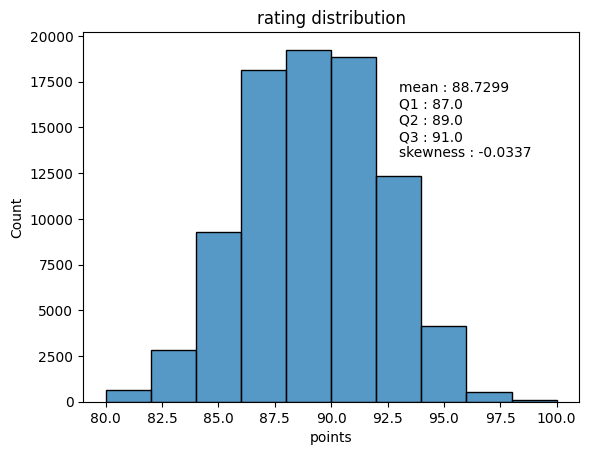

In [ ]:
ann_txt = f"""
mean : {round(df.points.mean(), 4)}
Q1 : {df.points.quantile(0.25)}
Q2 : {df.points.quantile(0.5)}
Q3 : {df.points.quantile(0.75)}
skewness : {round(df.points.skew(), 4)}
"""

plot = sns.histplot(
    data = df,
    x = 'points',
    bins = 10,
    )

plot.set_title("rating distribution")

plot.annotate(
    text = ann_txt,
    xy = (df.points.quantile(0.9), 12500)
    )
del ann_txt

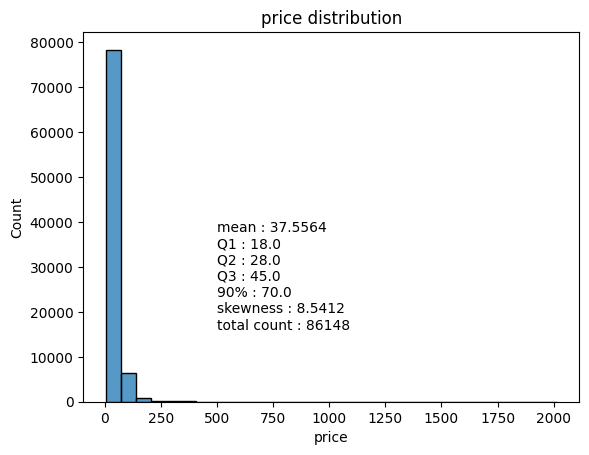

In [ ]:
ann_txt = f"""
mean : {round(df.price.mean(), 4)}
Q1 : {df.price.quantile(0.25)}
Q2 : {df.price.quantile(0.5)}
Q3 : {df.price.quantile(0.75)}
90% : {df.price.quantile(0.9)}
skewness : {round(df.price.skew(), 4)}
total count : {df.shape[0]}
"""

big_plot = sns.histplot(
    data = df,
    x = 'price',
    bins = 30,
    )

big_plot.set_title("price distribution")

big_plot.annotate(
    text = ann_txt,
    xy = (500, 12500)
    )

del ann_txt

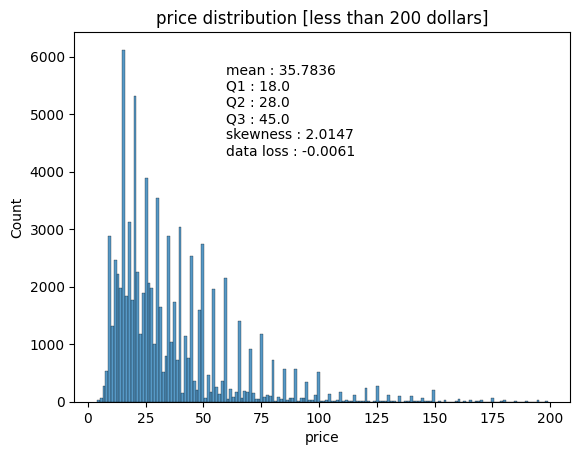

In [ ]:
trim_df = df.query('price < 200')  #narrow down to 0 - 100

ann_txt = f"""
mean : {round(trim_df.price.mean(), 4)}
Q1 : {trim_df.price.quantile(0.25)}
Q2 : {trim_df.price.quantile(0.5)}
Q3 : {trim_df.price.quantile(0.75)}
skewness : {round(trim_df.price.skew(), 4)}
data loss : {round(trim_df.shape[0] / df.shape[0] - 1, 4)}
"""

small_plot = sns.histplot(
    data = trim_df,
    x = 'price'
    )

small_plot.set_title("price distribution [less than 200 dollars]")

small_plot.annotate(
    text = ann_txt,
    xy = (60, 4000)
    )

del trim_df, ann_txt

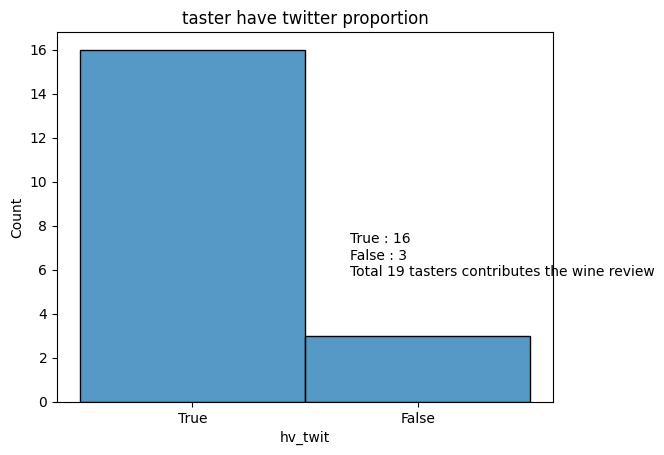

In [ ]:
df_ = (
    df
    .get(['hv_twit', 'taster_name'])
    .drop_duplicates()
    .query('taster_name != "annoymous"')
    .applymap(str)
)

plot = sns.histplot(
    data = df_,
    x = 'hv_twit'
    )

plot.set_title('taster have twitter proportion')

ann_txt = f"""
True : {df_.query("hv_twit == 'True'").shape[0]}
False : {df_.query("hv_twit != 'True'").shape[0]}
Total {df_.shape[0]} tasters contributes the wine review
"""

plot.annotate(
    text = ann_txt,
    xy = (0.7, 5)
    )

del df_, ann_txt

## Bi-Varient Analysis
### 1. country level:
- taster review count
- taster involvment
- designation
- variety
- provience
- review points
- winery

In [ ]:
print("group by country")

(
    df
    .groupby('country')
    .agg(
        {
            "taster_name"          : 'nunique',
            'winery'               : 'nunique',
            'designation'          : 'nunique',
            'variety'              : 'nunique',
            'price'                : 'mean',
            'region_1'             : 'nunique',
            'points'               : 'mean',
            'taster_twitter_handle': 'nunique',
            'title'                : 'count'
            }
        )
    .rename({'title': 'total_review_count'}, axis = 'columns')
    .sort_values(by = ['total_review_count'], ascending = False)
    .corr()
    # .transform(
    #     lambda x: abs(x).between(0.65, 0.9999999)
    #     # if the absolute correlation is between 0.65 and 0.9999, that is strong relationship
    #     )
    .style
    .applymap(lambda cell: 'opacity: 20%;' if cell < 0.5 or cell >= 1 else None)
)

group by country


,taster_name,winery,designation,variety,price,region_1,points,taster_twitter_handle,total_review_count
taster_name,1.000000,0.870499,0.892144,0.853691,0.445616,0.675466,0.236183,0.974656,0.894505
winery,0.870499,1.000000,0.987706,0.940291,0.416201,0.882010,0.187616,0.899915,0.971169
designation,0.892144,0.987706,1.000000,0.919965,0.395561,0.814686,0.191648,0.912396,0.994879
variety,0.853691,0.940291,0.919965,1.000000,0.466050,0.842899,0.193560,0.875037,0.892905
price,0.445616,0.416201,0.395561,0.466050,1.000000,0.434636,0.601595,0.427228,0.365090
region_1,0.675466,0.882010,0.814686,0.842899,0.434636,1.000000,0.186176,0.733122,0.762017
points,0.236183,0.187616,0.191648,0.193560,0.601595,0.186176,1.000000,0.230677,0.174894
taster_twitter_handle,0.974656,0.899915,0.912396,0.875037,0.427228,0.733122,0.230677,1.000000,0.909271
total_review_count,0.894505,0.971169,0.994879,0.892905,0.365090,0.762017,0.174894,0.909271,1.000000


In [ ]:
print("groupped_by_taster_name")

(
    df
    .groupby('taster_name')
    .agg(
        {
            'winery'               : 'nunique',
            'designation'          : 'nunique',
            'variety'              : 'nunique',
            'price'                : 'mean',
            'region_1'             : 'nunique',
            'points'               : 'mean',
            'taster_twitter_handle': 'nunique',
            'title'                : 'count',
            'country'              : 'nunique'
            }
        )
    .corr()
    .style
    .applymap(lambda cell: 'opacity: 20%;' if abs(cell) < 0.5 or cell >= 1 else None)
)


groupped_by_taster_name


,winery,designation,variety,price,region_1,points,taster_twitter_handle,title,country
winery,1.000000,0.981164,0.947599,0.382514,0.965398,0.041036,-0.150526,0.959480,0.365154
designation,0.981164,1.000000,0.952184,0.407384,0.927055,0.104069,-0.105727,0.988548,0.320708
variety,0.947599,0.952184,1.000000,0.250328,0.872054,0.016246,-0.104351,0.953272,0.462980
price,0.382514,0.407384,0.250328,1.000000,0.416533,0.498243,0.053443,0.356795,-0.382545
region_1,0.965398,0.927055,0.872054,0.416533,1.000000,0.019320,-0.203868,0.869801,0.339584
points,0.041036,0.104069,0.016246,0.498243,0.019320,1.000000,0.430047,0.099893,-0.166988
taster_twitter_handle,-0.150526,-0.105727,-0.104351,0.053443,-0.203868,0.430047,1.000000,-0.074331,-0.232275
title,0.959480,0.988548,0.953272,0.356795,0.869801,0.099893,-0.074331,1.000000,0.319150
country,0.365154,0.320708,0.462980,-0.382545,0.339584,-0.166988,-0.232275,0.319150,1.000000


In [ ]:
print("group by designation")

(
    df
    .groupby('designation')
    .agg(
        {
            'winery'               : 'nunique',
            'taster_name'          : 'nunique',
            'variety'              : 'nunique',
            'price'                : 'mean',
            'region_1'             : 'nunique',
            'points'               : 'mean',
            'taster_twitter_handle': 'nunique',
            'title'                : 'count',
            'country'              : 'nunique'
            }
        )
    .corr()
    .style
    .applymap(lambda cell: 'opacity: 20%;' if abs(cell) < 0.5 or cell >= 1 else None)
)


group by designation


,winery,taster_name,variety,price,region_1,points,taster_twitter_handle,title,country
winery,1.000000,0.482973,0.715994,-0.003463,0.848584,-0.000386,0.359834,0.974777,0.615344
taster_name,0.482973,1.000000,0.633286,0.014366,0.628283,0.026273,0.665315,0.450044,0.699672
variety,0.715994,0.633286,1.000000,-0.042979,0.762912,-0.041483,0.483269,0.732107,0.695985
price,-0.003463,0.014366,-0.042979,1.000000,0.007600,0.486172,-0.009891,-0.003138,-0.019285
region_1,0.848584,0.628283,0.762912,0.007600,1.000000,-0.012422,0.444919,0.819409,0.705463
points,-0.000386,0.026273,-0.041483,0.486172,-0.012422,1.000000,0.081431,0.004056,-0.023771
taster_twitter_handle,0.359834,0.665315,0.483269,-0.009891,0.444919,0.081431,1.000000,0.331447,0.547599
title,0.974777,0.450044,0.732107,-0.003138,0.819409,0.004056,0.331447,1.000000,0.564492
country,0.615344,0.699672,0.695985,-0.019285,0.705463,-0.023771,0.547599,0.564492,1.000000


In [ ]:
print("group by verity")

(
    df
    .groupby('variety')
    .agg(
        {
            'winery'               : 'nunique',
            'taster_name'          : 'nunique',
            'designation'          : 'nunique',
            'price'                : 'mean',
            'region_1'             : 'nunique',
            'points'               : 'mean',
            'taster_twitter_handle': 'nunique',
            'title'                : 'count',
            'country'              : 'nunique'
            }
        )
    .corr()
    .style
    .applymap(lambda cell: 'opacity: 20%;' if abs(cell) < 0.5 or cell >= 1 else None)
)


group by verity


,winery,taster_name,designation,price,region_1,points,taster_twitter_handle,title,country
winery,1.000000,0.672985,0.980227,0.053106,0.958336,0.055101,0.649102,0.951002,0.838077
taster_name,0.672985,1.000000,0.629811,0.063731,0.766018,0.093575,0.981118,0.609958,0.853589
designation,0.980227,0.629811,1.000000,0.055528,0.908840,0.063524,0.608691,0.983775,0.791501
price,0.053106,0.063731,0.055528,1.000000,0.046408,0.428604,0.065766,0.060143,0.047100
region_1,0.958336,0.766018,0.908840,0.046408,1.000000,0.044057,0.742834,0.858429,0.903631
points,0.055101,0.093575,0.063524,0.428604,0.044057,1.000000,0.112773,0.068214,0.057991
taster_twitter_handle,0.649102,0.981118,0.608691,0.065766,0.742834,0.112773,1.000000,0.589628,0.838119
title,0.951002,0.609958,0.983775,0.060143,0.858429,0.068214,0.589628,1.000000,0.755846
country,0.838077,0.853589,0.791501,0.047100,0.903631,0.057991,0.838119,0.755846,1.000000


In [ ]:
print("group by verity")

(
    df
    .groupby('winery')
    .agg(
        {
            'winery'               : 'nunique',
            'taster_name'          : 'nunique',
            'designation'          : 'nunique',
            'price'                : 'mean',
            'region_1'             : 'nunique',
            'points'               : 'mean',
            'taster_twitter_handle': 'nunique',
            'title'                : 'count',
            'country'              : 'nunique',
            'variety'              : 'nunique'
            }
        )
    .corr()
    .dropna(axis = 'rows', how = "all")
    .dropna(axis = 'columns', how = 'all')
    .style
    .applymap(lambda cell: 'opacity: 20%;' if abs(cell) < 0.5 or cell >= 1 else None)
)


group by verity


,taster_name,designation,price,region_1,points,taster_twitter_handle,title,country,variety
taster_name,1.000000,0.471018,0.102736,0.425835,0.115039,0.596567,0.459997,0.202531,0.469989
designation,0.471018,1.000000,0.076402,0.493267,0.159906,0.356739,0.901099,0.120662,0.694433
price,0.102736,0.076402,1.000000,0.092398,0.518023,0.004965,0.066414,-0.015114,-0.033015
region_1,0.425835,0.493267,0.092398,1.000000,0.082411,0.268620,0.433837,0.151235,0.381366
points,0.115039,0.159906,0.518023,0.082411,1.000000,0.144757,0.150542,-0.019330,0.019126
taster_twitter_handle,0.596567,0.356739,0.004965,0.268620,0.144757,1.000000,0.348079,0.178324,0.348457
title,0.459997,0.901099,0.066414,0.433837,0.150542,0.348079,1.000000,0.090152,0.704231
country,0.202531,0.120662,-0.015114,0.151235,-0.019330,0.178324,0.090152,1.000000,0.127359
variety,0.469989,0.694433,-0.033015,0.381366,0.019126,0.348457,0.704231,0.127359,1.000000


<Axes: title={'center': 'review count by country and taster'}, xlabel='country'>

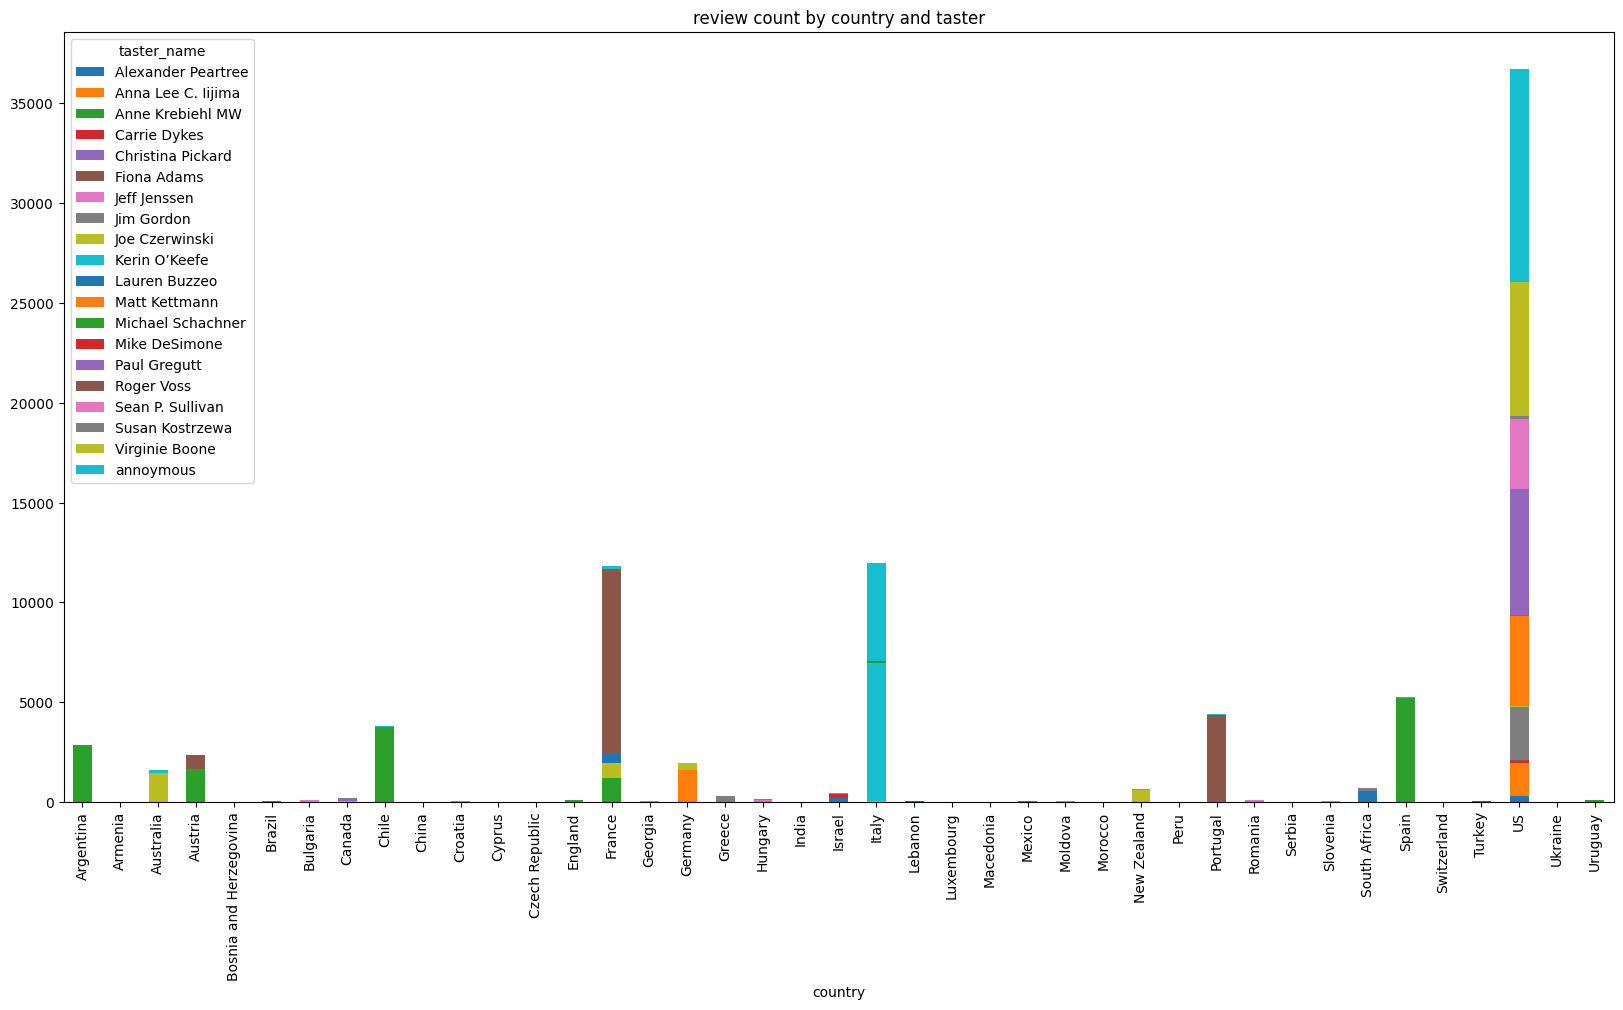

In [ ]:
# with larger fig size
# sorted by total review count
pd.pivot_table(
    data = df,
    index = 'country',
    columns = 'taster_name',
    values = 'title',
    aggfunc = 'count'
).plot(kind='bar', stacked=True, figsize=(20,10), title = 'review count by country and taster')
